# Solvent Small Experiment

Question: Could be use data from minotiry solvents? Does it add value/relevant information?

Descriptions:
- 3 solvent availables, one majority and two minorities
- sample from majority and minorities: 3 samples
- train in majority
- evaluate in 3 samples and compare results, is any particular improvement in majority?

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from src.config import chemical_inventory_path, raw_data_path
from src.data import notebook_utils as utils
from src.constants import GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY, \
                        INCHI_TO_CHEMNAME, TARGET_COL, RXN_FEAT_NAME, ORGANOAMONIUM_INCHI_KEY_COL
from src import plot_utils

In [249]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.reload_library()
import matplotlib.patches as mpatches

## Generate datasets

Sample from major

In [2]:
%cd ../..

/home/belu/VS Workplace/licentiate-thesis-repo


In [252]:
SEED = 301
ALGORITHM = 'rf'

solvents_inchies = [GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY]
solvents = [INCHI_TO_CHEMNAME[inchie] for inchie in solvents_inchies]

plot_solvents = {'Gamma-Butyrolactone': "GBL",
                 'Dimethyl sulfoxide':"DMSO",
                 'Dimethylformamide': "DMF"}

solvents_data = {INCHI_TO_CHEMNAME[solvent_inchie]: utils.read_data(raw_data_path, organic_key=True,\
                                                                    solvent=solvent_inchie) \
                 for solvent_inchie in solvents_inchies}

In [258]:
for solvent, data in solvents_data.items():
    
    print(solvent, len(data[ORGANOAMONIUM_INCHI_KEY_COL].unique()))

Gamma-Butyrolactone 29
Dimethyl sulfoxide 6
Dimethylformamide 9


In [277]:
solvents_data['Dimethylformamide'].columns

Index(['_feat_WienerPolarity', '_feat_BondCount', '_feat_fr_NH0',
       '_feat_Refractivity', '_feat_LargestRingSize', '_feat_fr_ArN',
       '_feat_HeteroaliphaticRingCount', '_feat_fr_quatN', '_feat_msareaVDWp',
       '_feat_AromaticAtomCount', '_feat_AtomCount_C', '_feat_fr_amidine',
       '_feat_CyclomaticNumber', '_feat_LengthPerpendicularToTheMinArea',
       '_feat_fr_guanido', '_feat_donorcount', '_feat_molsurfaceareaVDWp',
       '_feat_fr_NH2', '_feat_minimalprojectionsize', '_feat_AtomCount_N',
       '_feat_ChiralCenterCount', '_feat_WienerIndex', '_feat_AvgPol',
       '_feat_donsitecount', '_feat_Hacceptorcount', '_feat_ASA-',
       '_feat_ProtPolarSurfaceArea', '_feat_fr_Ar_NH',
       '_feat_HeteroaromaticRing Count', '_feat_Accsitecount',
       '_feat_acceptorcount', '_feat_ASA', '_feat_CarboaromaticRingCount',
       '_feat_BalabanIndex', '_feat_SmallestRingSize', '_feat_RingAtomCount',
       '_feat_msareaASAp', '_feat_PolarSurfaceArea',
       '_feat_MinimalPro

In [262]:
len(feats)

67

In [51]:
solvent_data_eval_sample = { solvent: data.groupby([TARGET_COL, ORGANOAMONIUM_INCHI_KEY_COL])\
                            .sample(frac=0.2, random_state=SEED)\
                            .drop([ORGANOAMONIUM_INCHI_KEY_COL], axis=1) \
                            for solvent, data in solvents_data.items()}

In [52]:
for solvent, data in solvent_data_eval_sample.items():
    print(solvent, len(data))

Gamma-Butyrolactone 1219
Dimethyl sulfoxide 172
Dimethylformamide 218


In [53]:
solvent_data_remain_sample = { solvent: data.loc[~data.index\
                                                 .isin(solvent_data_eval_sample[solvent].index)]\
                            for solvent, data in solvents_data.items()}

In [54]:
for solvent, data in solvent_data_remain_sample.items():
    print(solvent, len(data))

Gamma-Butyrolactone 4877
Dimethyl sulfoxide 692
Dimethylformamide 878


### Concentration distribution

In [28]:
concentrations_feats = utils.concentration_feats() + [TARGET_COL]

In [29]:
full_rxn_sample = pd.concat([data[concentrations_feats] for data in solvents_data.values()], axis=0).reset_index(drop=True)

In [ ]:
with plt.style.context(['science', 'bright']):
    light = sns.color_palette()

In [161]:
bright = plot_utils.tol_cset("light")
bright

Lcset(light_blue='#77AADD', orange='#EE8866', light_yellow='#EEDD88', pink='#FFAABB', light_cyan='#99DDFF', mint='#44BB99', pear='#BBCC33', olive='#AAAA00', pale_grey='#DDDDDD', black='#000000')

In [237]:
def plot_pair_solvent(df, title=""):
    
    cols_name_map = {
    '_rxn_M_inorganic': "reactivo inorgánico",
    '_rxn_M_organic': "reactivo orgánico",
    '_rxn_M_acid': "ácido",
    }

    df = df.rename(cols_name_map, axis=1)

    #norm = plt.Normalize(1, 300)
    #sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(full_rxn_sample.max().max(), start=.5, rot=-.75,as_cmap=True), norm=norm)
    #sm.set_array([])
    
    with plt.style.context(['science', 'bright']):
        paleta = [bright.light_blue, bright.orange]
        g = sns.pairplot(df, hue=TARGET_COL, kind='hist',
                         palette=paleta, plot_kws={"bins":33,
                                                   "cbar":False
                                                  }, diag_kws={'bins':15} )
        g.fig.suptitle(title, y=1.01)
        g._legend.remove()
        for ax in g.axes.flatten():
            ax.tick_params(which="both", left=True, bottom=False, top=False, right=False)
        #ax.fig.suptitle(plot_solvents[amine_name], y=1.08)
        pop_a = mpatches.Patch(facecolor=paleta[0], label="No cristaliza", edgecolor='grey')
        pop_b = mpatches.Patch(facecolor=paleta[1], label="Cristaliza", edgecolor='grey')

        plt.legend(handles=[pop_a,pop_b], bbox_to_anchor = (1.7, 1.6))
        
        #cbar_ax = g.fig.add_axes([1.015,0.13, 0.015, 0.8])
        #plt.colorbar(sm, cax=cbar_ax)
        #cbar = plt.colorbar(sm, ax=g.axes)
        g.fig.savefig("figures/solvent_dist_full.pdf", dpi=300) 

In [235]:
import matplotlib as mpl

cmap = mpl.cm.cmaps_listed


schemes = tol_cmap()
tol_cmap(schemes[0])

norm = plt.Normalize(1, 300)
sm = plt.cm.ScalarMappable(cmap=newcmp, norm=norm)
sm.set_array([])

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ['#2166AC', '#4393C3', '#92C5DE', '#D1E5F0']
newcmp = ListedColormap(colors)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp)
sm.set_array([])

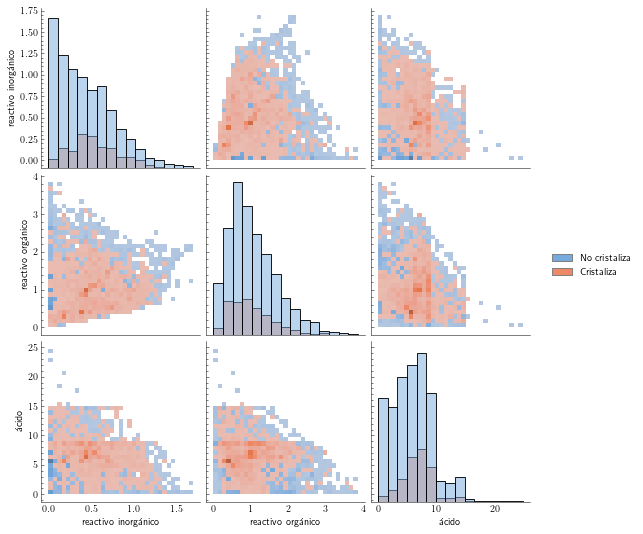

In [238]:
plot_pair_solvent(full_rxn_sample)

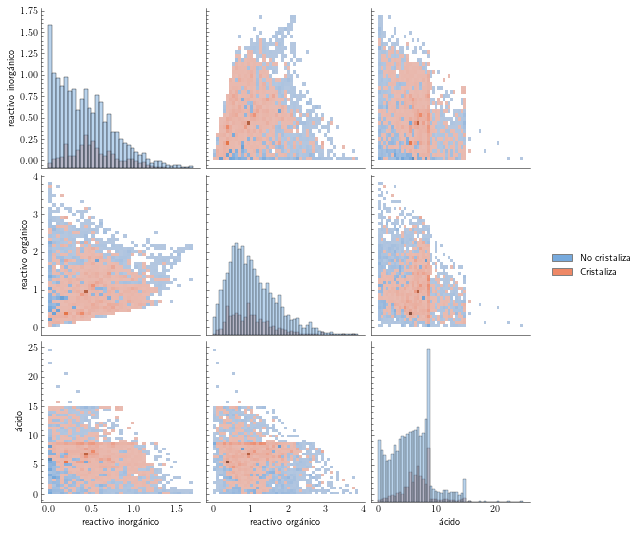

In [115]:
plot_pair_solvent(full_rxn_sample)

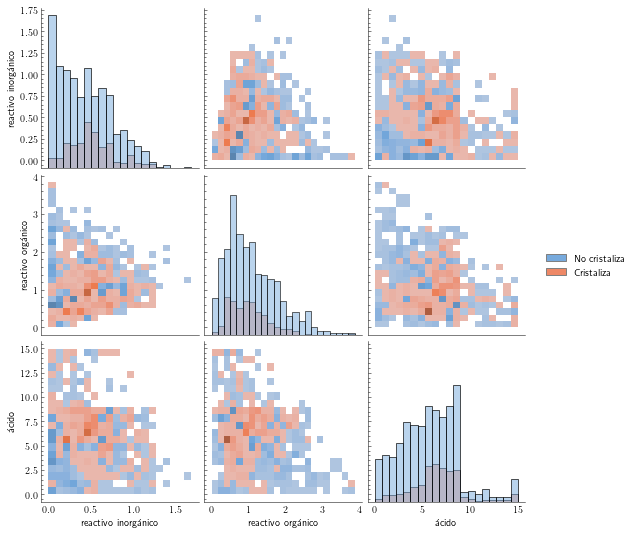

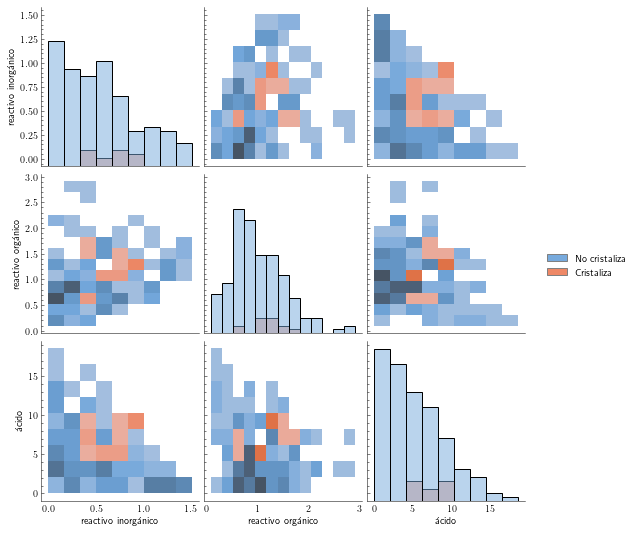

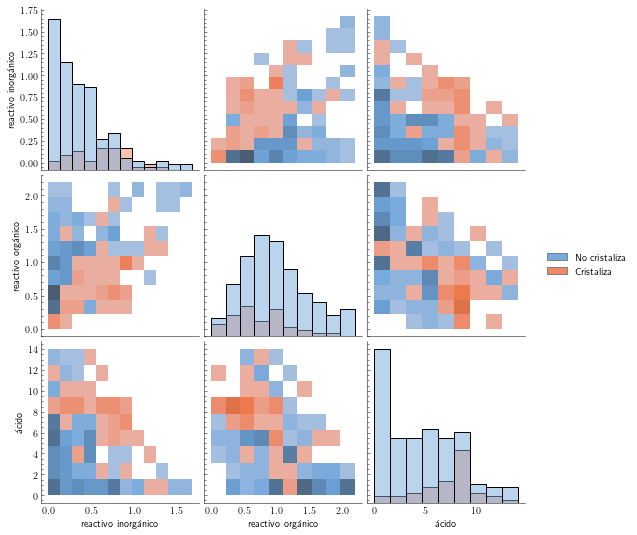

In [112]:
for amine_name in solvents:
    plot_pair_solvent(solvent_data_eval_sample[amine_name][concentrations_feats])

AttributeError: 'numpy.ndarray' object has no attribute 'tick_params'

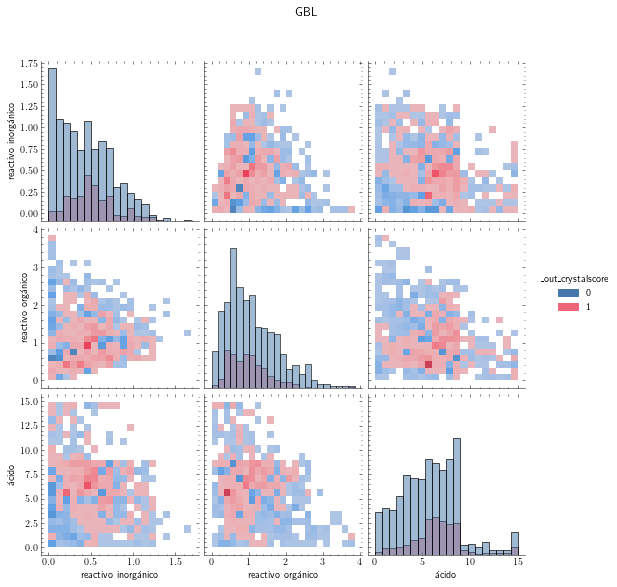

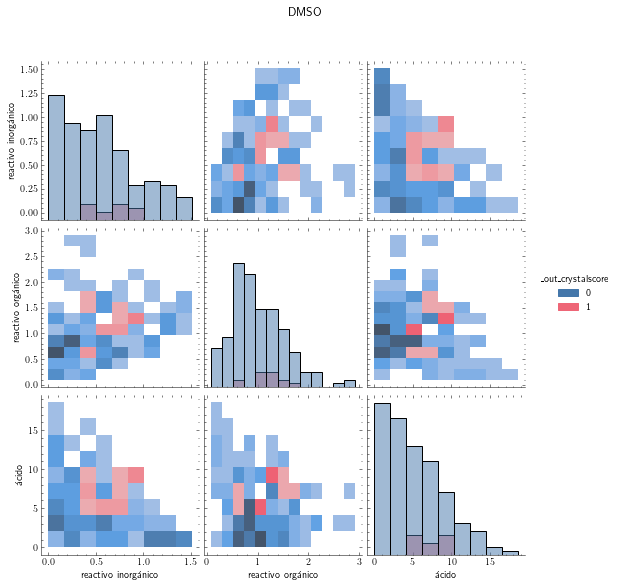

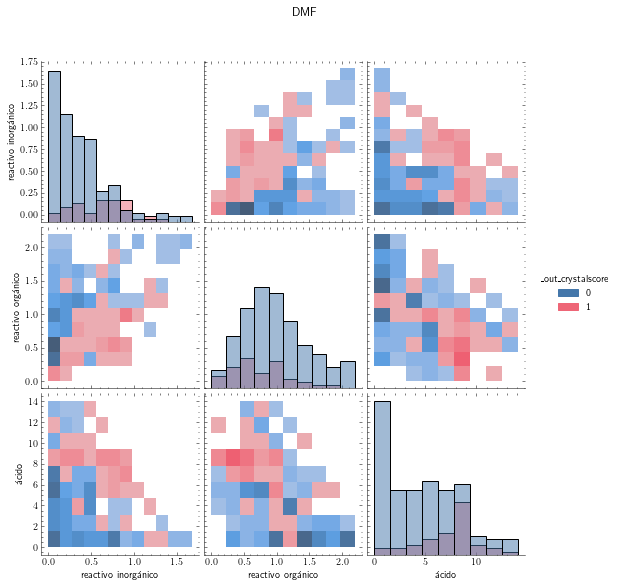

In [75]:
plot_title = "figures/dist_reactivos"

#plotting_rxn = solvent_data_eval_sample.rename(cols_name_map, axis=1)

def binary_name(row):
    return 'Cristaliza' if row[TARGET_COL] == 1 else "No cristaliza"
    
#plotting_rxn["Clase"] = solvent_data_eval_sample.apply(binary_name, axis=1)

with plt.style.context(['science', 'bright']):
    for ax, amine_name in zip(axes.flatten(), solvents):
        ax = sns.pairplot(solvent_data_eval_sample[amine_name] \
                          [concentrations_feats].rename(cols_name_map, axis=1),
                          hue=TARGET_COL, kind='hist')
        ax.tick_params(which="both", left=True, bottom=False, top=False, right=False)
        ax.fig.suptitle(plot_solvents[amine_name], y=1.08)
    #ax.figure.savefig("figures/solvent_%s_dist_rxn.png" % amine_name) 

## Proof of concept models

In [32]:
model_cols = utils.get_deafult_model_columns()

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
import sklearn.ensemble as ensamble_models
import sklearn.neighbors as neighbors_models
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as linear_models

In [34]:
def make_model(model_name, model_config={}):
    try:
        model_method = getattr(neighbors_models, model_name)
    except AttributeError: 
        try:
            model_method = getattr(ensamble_models, model_name)
        except AttributeError:
            model_method = getattr(linear_models, model_name)
    
    model = model_method(**model_config)
    return model

def split_X_y(df):
    X = df.drop([TARGET_COL], axis=1).values
    y = df[TARGET_COL].values
    return X, y

def proof_concept(model_name, df_train, df_test, model_config = {}):
    model = make_model(model_name, model_config)
    
    X_test, y_test = split_X_y(df_test)
    X_train, y_train = split_X_y(df_train)
    
    pipeline_steps = [('std', StandardScaler()), 
                      ('model', model)
                     ]
    
    pipeline = Pipeline(steps=pipeline_steps)
    
    pipeline.fit(X_train, y_train)
    
    y_pred =  pipeline.predict(X_test)
    
    report = classification_report(y_test, y_pred, labels=[0,1], 
                                   output_dict=True, target_names=["No cristaliza", "Cristaliza"])
    
    return report
    
def full_pipeline(X, y, model, k_fold_config):
    
    pipeline_steps = [('std', StandardScaler()), 
                      ('model', model)
                     ]
    pipeline = Pipeline(steps=pipeline_steps)
    
    cv = RepeatedStratifiedKFold(**k_fold_config)
    
    scores = cross_validate(pipeline, X, y, cv=cv,
                         scoring=('recall', 'f1', 'precision'),
                         return_train_score=True, return_estimator=True)
    
    #df_res = pd.DataFrame(scores)
    return scores

In [35]:
models = {
    'knn':'KNeighborsClassifier',
    'rf':'RandomForestClassifier',
    'gbc':'GradientBoostingClassifier'
}

n_repeat_k_fold = 2
k_splits = 3

k_fold_config = {
    'random_state': SEED,
    'n_repeats': n_repeat_k_fold,
    'n_splits': k_splits,
}

#### Similar distributions?

In [55]:
df_train = solvent_data_remain_sample['Gamma-Butyrolactone'][model_cols]

In [56]:
report_isolated_GBL = {solvent: proof_concept(models[ALGORITHM], df_train, df_test) \
                        for solvent, df_test in solvent_data_eval_sample.items() }

/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

In [57]:
for solvent in solvents:
    report =  pd.DataFrame(report_isolated_GBL[solvent]).transpose()
    report.to_csv('results/only_GBL_tested_in_%s_%s_%s.csv' % (solvent, ALGORITHM, SEED), index=None)

In [58]:
report.index

Index(['No cristaliza', 'Cristaliza', 'accuracy', 'macro avg', 'weighted avg'], dtype='object')

#### Discrimination by solvent feature

Generate full dataset with solvent one hot encoded

In [59]:
def add_column(df, solvent):
    df['solvent'] = solvent
    return df

df_full_with_solvent = pd.concat([data.apply(add_column, axis=1, args=(solvent,)) \
                             for solvent, data in solvents_data.items()], axis=0)\
                            .reset_index(drop=True)

In [60]:
df_full_dummies = pd.get_dummies(df_full_with_solvent, columns = ['solvent'])

In [61]:
df_full_dummies['solvent'] = df_full_with_solvent['solvent']

Split by solvent to sample

In [62]:
df_by_solvent= {solvent: df_full_dummies.query('solvent == @solvent')
                        for solvent in solvents
                        }

In [63]:
df_solvent_samples_test = { solvent: data.groupby([TARGET_COL, ORGANOAMONIUM_INCHI_KEY_COL])\
                            .sample(frac=0.2, random_state=SEED)\
                            .drop([ORGANOAMONIUM_INCHI_KEY_COL, 'solvent'], axis=1) \
                            for solvent, data in df_by_solvent.items()}

In [64]:
for solvent, data in df_solvent_samples.items():
    print(solvent, len(data))

NameError: name 'df_solvent_samples' is not defined

In [ ]:
df_solvent_samples_train = { solvent: data.loc[~data.index\
                                                 .isin(df_solvent_samples_test[solvent].index)]\
                            for solvent, data in df_by_solvent.items()}

In [ ]:
for solvent, data in df_solvent_samples_train.items():
    print(solvent, len(data))

Generate train dataset merging train samples from all solvent

In [ ]:
df_solvent_full_train = pd.concat([data for solvent, data in df_solvent_samples_train.items()],
                                  axis=0).reset_index(drop=True)

In [ ]:
df_solvent_full_train = df_solvent_full_train.drop([ORGANOAMONIUM_INCHI_KEY_COL, 'solvent'], axis=1)

In [ ]:
df_solvent_report = {solvent: proof_concept(models[ALGORITHM], df_solvent_full_train, df_test) \
                        for solvent, df_test in df_solvent_samples_test.items() }

In [ ]:
for solvent in solvents:
    report =  pd.DataFrame(df_solvent_report[solvent]).transpose()
    report.to_csv('results/solvent-encoded_%s_%s_%s.csv' % (solvent, ALGORITHM, SEED), index=None)